In [22]:
# Import a Kalman filter and other libraries
!pip install pykalman
!pip install qq-training-wheels auquan_toolbox --upgrade
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (10,7)


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip
  Using cached qq_training_wheels-0.0.1-py3-none-any.whl (5.0 kB)
  Using cached auquan_toolbox-2.1.92-py3-none-any.whl (103 kB)
  Using cached bs4-0.0.1.tar.gz (1.1 kB)
  Preparing metadata (setup.py) ... - done
  Using cached sklearn-0.0.post10.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by o

<ipython-input-22-3013c9e87d33>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


Time Series1:  1.2% is missing (428263 ==> 423020)
Time Series2:  0.5% is missing (425135 ==> 423020)


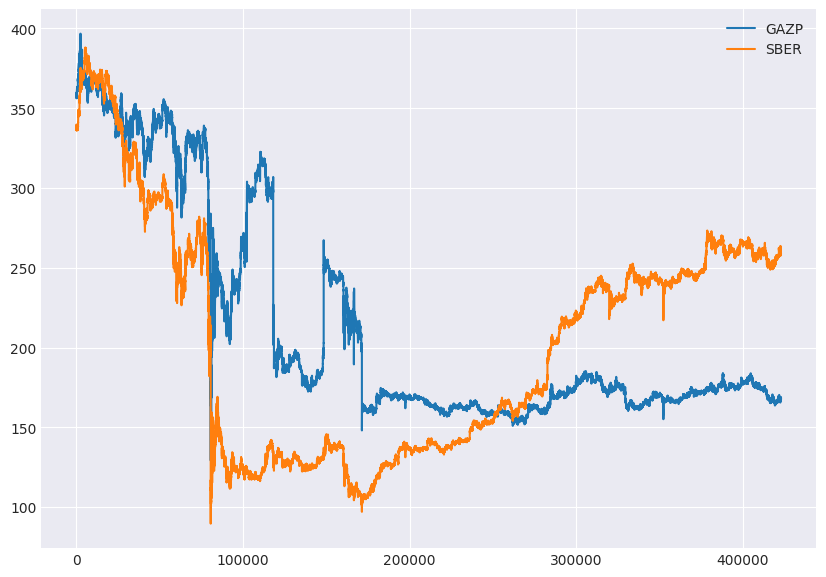

In [23]:
def match_ts(ts1: pd.DataFrame, ts2: pd.DataFrame, join_with: str = None):
    """ Match two Time Series data (DataFrames) by time"""
    init_shape = [ts.shape[0] for ts in [ts1, ts2]]
    ts1 = pd.merge(ts1, ts2['time'], on='time', how='inner')
    ts2 = pd.merge(ts2, ts1['time'], on='time', how='inner')
    res_shape = [ts.shape[0] for ts in [ts1, ts2]]
    pct = [100.0 * round(float(init_shape[i] - res_shape[i]) / init_shape[i], 3) for i in range(2)]
    for i in range(2):
        print(f'Time Series{i+1}:  {pct[i]}% is missing ({init_shape[i]} ==> {res_shape[i]})')
    if join_with is not None:
        res = pd.DataFrame()
        res['time'] = ts1['time']
        res['ts1'] = ts1[join_with]
        res['ts2'] = ts2[join_with]
        return res
    else:
        return ts1, ts2
    
data = pd.read_csv('SBER_GAZP.csv')

s1 = data.loc[data['ticker'] == 'GAZP']
s2 = data.loc[data['ticker'] == 'SBER']

s1, s2 = match_ts(s1, s2)

plt.plot(s1['close'], label='GAZP')
plt.plot(s2['close'], label='SBER')
plt.legend()
plt.show()

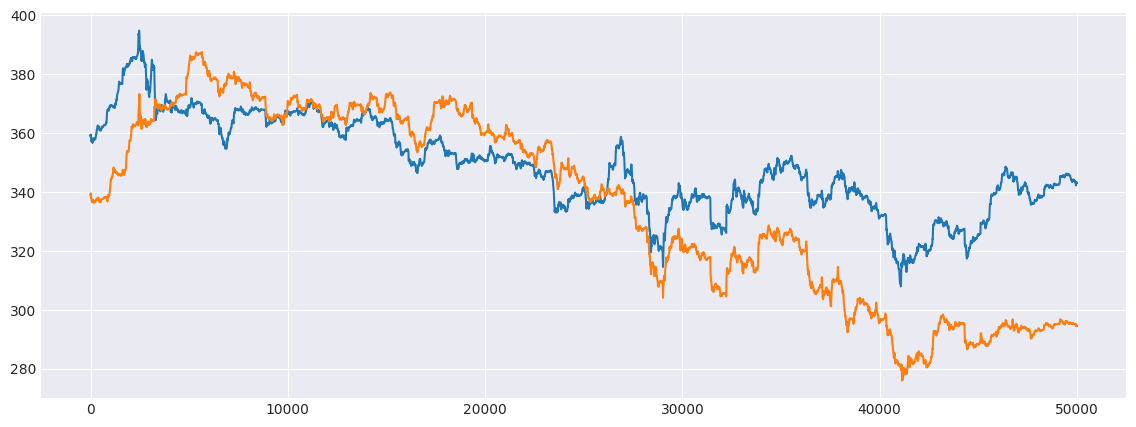

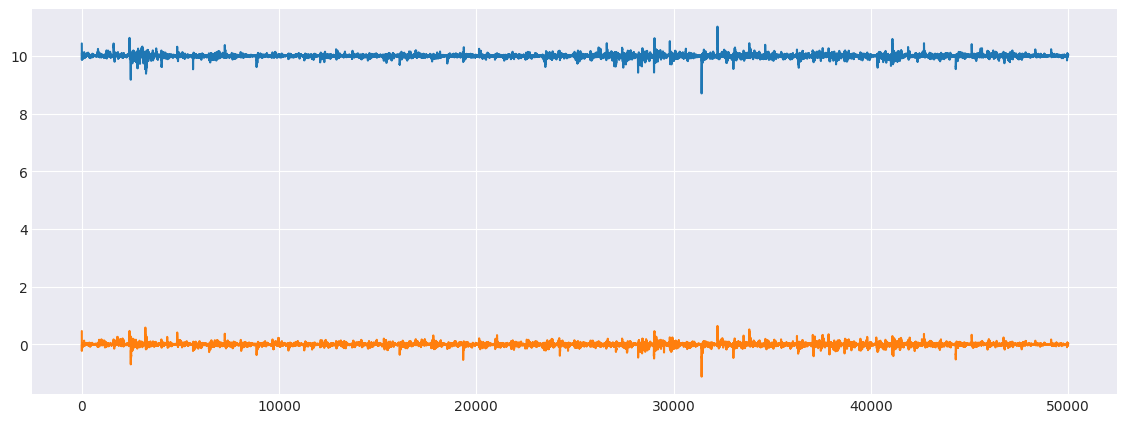

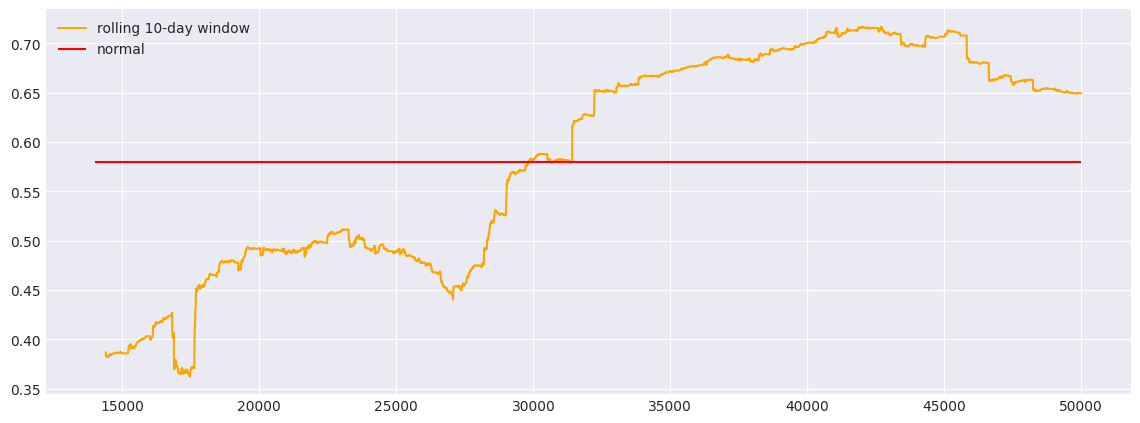

In [24]:
# smoothing
s1 = s1.close.ewm(10).mean()
s2 = s2.close.ewm(10).mean()

plt.figure(figsize=(14, 5))
plt.plot(s1[:50000])
plt.plot(s2[:50000])
plt.show()

ss1 = pd.Series(np.diff(s1.values[:50000]))
ss2 = pd.Series(np.diff(s2.values[:50000]))

plt.figure(figsize=(14, 5))
plt.plot(ss1+10)
plt.plot(ss2)
plt.show()


# plt.plot(ss1, ss2, 'o')
# plt.show()


plt.figure(figsize=(14, 5))
plt.plot(ss1.rolling(10*24*60).corr(ss2)[14000:], label='rolling 10-day window', color='orange')
plt.hlines(np.corrcoef(ss1, ss2)[0][1], xmin=14000, xmax=50000, label='normal', color='red')
plt.legend()
plt.show()

In [25]:
def calc_slope_intercept_kalman(etfs, prices, delta = 1e-5):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[etfs[0]], np.ones(prices[etfs[0]].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.array((0.35, 0)), # X_0
        initial_state_covariance=np.ones((2, 2)), # P 
        transition_matrices=np.eye(2), # F
        observation_matrices=obs_mat, 
        observation_covariance=1.0, # R
        transition_covariance=trans_cov # Q
    )
    
    state_means, state_covs = kf.filter(prices[etfs[1]].values)
    return state_means, state_covs

def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the 
    Kalman Filter calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True)
    plt.show()
    
    
def draw_date_coloured_scatterplot(etfs, prices):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the 
    changing relationship between the sets of prices    
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')    
    colours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[etfs[0]], prices[etfs[1]], 
        s=30, c=colours, cmap=colour_map, 
        edgecolor='k', alpha=0.8
    )
    
    # Add a colour bar for the date colouring and set the 
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

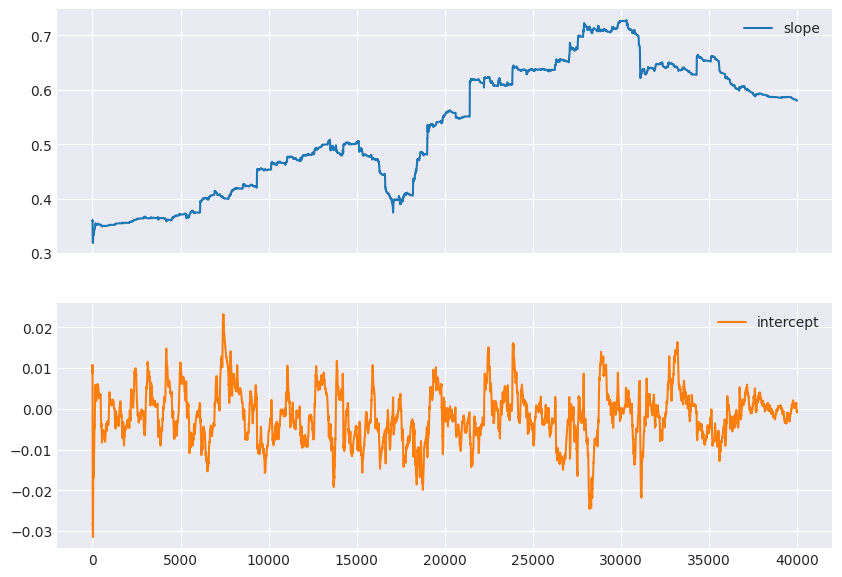

In [26]:
prices = pd.DataFrame({'SBER': ss1.values[10000:50000], 'GAZP': ss2.values[10000:50000]})
names = ['SBER', 'GAZP']

state_means, state_covs = calc_slope_intercept_kalman(names, prices, delta=1e-5)
draw_slope_intercept_changes(prices, state_means)

In [27]:
state_means2, state_covs2 = calc_slope_intercept_kalman(names, prices, delta=5e-5)

In [28]:
data.time

0 2021-10-01 07:00:00+00:00
1 2021-10-01 07:01:00+00:00
2 2021-10-01 07:02:00+00:00
3 2021-10-01 07:03:00+00:00
4 2021-10-01 07:04:00+00:00
 ... 
853393 2023-09-30 15:54:00+00:00
853394 2023-09-30 15:55:00+00:00
853395 2023-09-30 15:56:00+00:00
853396 2023-09-30 15:57:00+00:00
853397 2023-09-30 15:58:00+00:00
Name: time, Length: 853398, dtype: object

In [29]:
time = map(lambda datetime_str : datetime.strptime(datetime_str[:-9], '%Y-%m-%d %H:%M'), data.time.values[14400:50000])
time = pd.to_datetime(tuple(time))
time

DatetimeIndex(['2021-10-26 19:06:00', '2021-10-26 19:07:00',
               '2021-10-26 19:08:00', '2021-10-26 19:09:00',
               '2021-10-26 19:10:00', '2021-10-26 19:11:00',
               '2021-10-26 19:12:00', '2021-10-26 19:13:00',
               '2021-10-26 19:14:00', '2021-10-26 19:15:00',
               ...
               '2021-12-29 07:46:00', '2021-12-29 07:47:00',
               '2021-12-29 07:48:00', '2021-12-29 07:49:00',
               '2021-12-29 07:50:00', '2021-12-29 07:51:00',
               '2021-12-29 07:52:00', '2021-12-29 07:53:00',
               '2021-12-29 07:54:00', '2021-12-29 07:55:00'],
              dtype='datetime64[ns]', length=35600, freq=None)

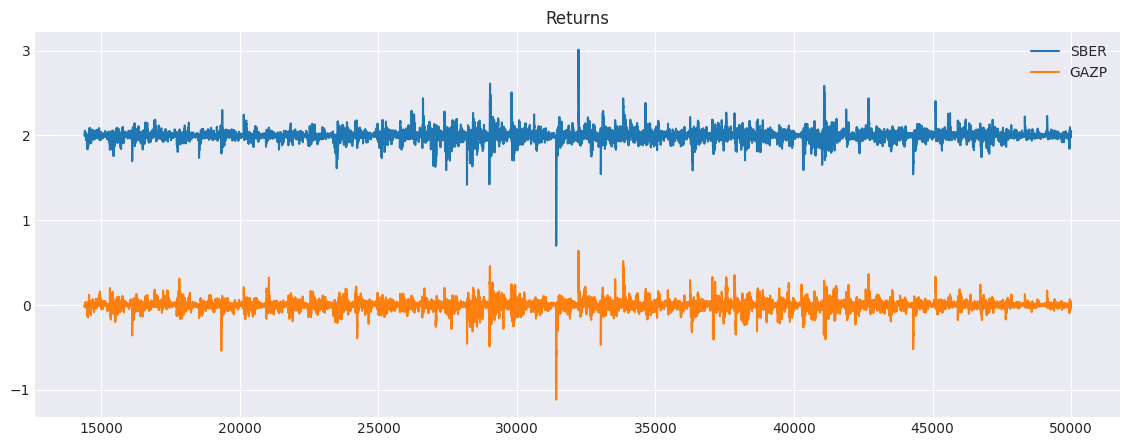

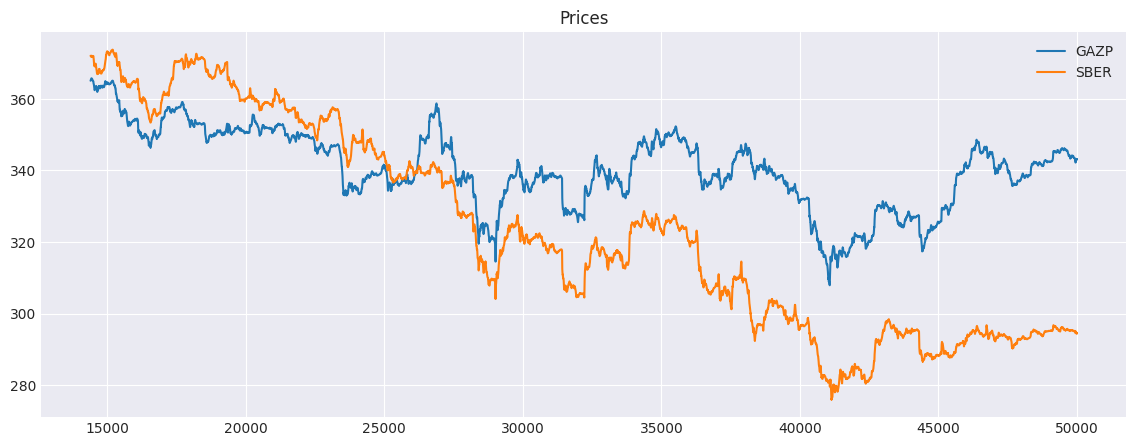

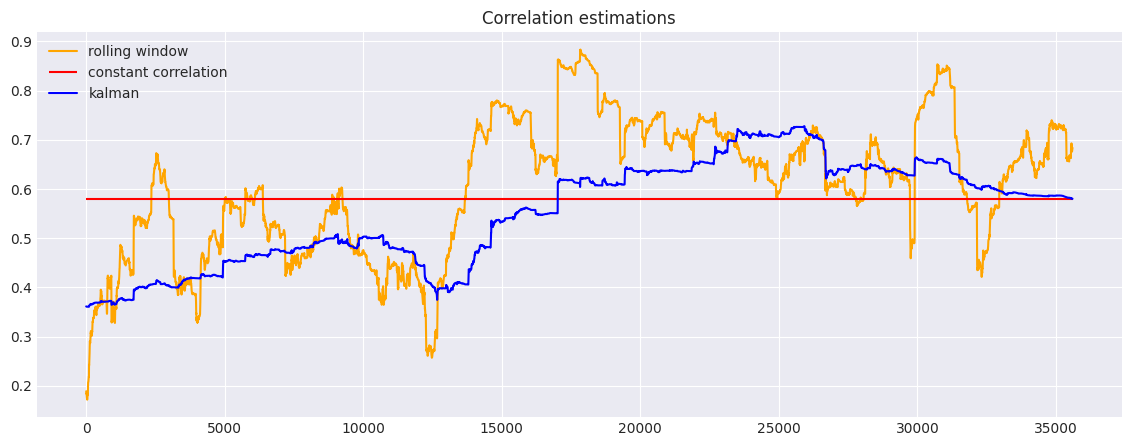

In [30]:
ss1 = pd.Series(np.diff(s1.values[:50000]))
ss2 = pd.Series(np.diff(s2.values[:50000]))

plt.figure(figsize=(14, 5))
plt.title('Returns')
plt.plot(ss1[14400:]+2, label = 'SBER')
plt.plot(ss2[14400:], label='GAZP')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.title('Prices')
plt.plot(s1[14400:50000], label='GAZP')
plt.plot(s2[14400:50000], label='SBER')
plt.legend()
plt.show()


# plt.plot(ss1, ss2, 'o')
# plt.show()
roll = ss1.rolling(10*24*60).corr(ss2)

plt.figure(figsize=(14, 5))

plt.plot(np.arange(0,35599), ss1.rolling(24*60).corr(ss2)[14400:], label='rolling window', color='orange')
plt.hlines(np.corrcoef(ss1[:50000], ss2[:50000])[0][1], xmin=0, xmax=35599, label='constant correlation', color='red')
plt.plot(state_means[:, 0][4400:], label='kalman', color='blue')
# plt.plot(np.arange(0,35599), state_means2[:, 0][4400:], label='kalman', color='blue')
plt.title('Correlation estimations')
plt.legend()
plt.show()